In [1]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
from salishsea_tools import geo_tools, geo_tools, tidetools
import functools
from IPython.display import clear_output
import datetime


%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [5]:
station_lon_lat = pd.read_pickle("/ocean/jpetrie/MEOPAR/analysis-james/station_location.pkl")

In [30]:
# converts lons/lats like this "124° 01.400" to decimal format
def strLonLatToDec(lstr):
    lstr = lstr.replace(u'°',' ')
    lstr = lstr.split()
    return (int(lstr[0])+float(lstr[1])/60.0)

In [34]:
# Grab nitrate data
nitrate_df = pd.read_excel('/ocean/rich/home/metro/venus_adcp/PSF/bottle/PSF_2015bottle_RPedit.xls')
nitrate_df = nitrate_df[~pd.isnull(nitrate_df["Date"]) & (nitrate_df["Date"] != "6/?/2015")]
nitrate_df["Date"] = pd.to_datetime(nitrate_df["Date"])
nitrate_df = nitrate_df.sort_values("Date")
nitrate_df["DECIMAL_LON"] = (nitrate_df["Longitude"].apply(strLonLatToDec))*(-1)
nitrate_df["DECIMAL_LAT"] = (nitrate_df["Latitude"].apply(strLonLatToDec))
nitrate_df["STATION_LAT"] =  nitrate_df.groupby("Station ID")["DECIMAL_LAT"].transform(np.median)
nitrate_df["STATION_LON"] =  nitrate_df.groupby("Station ID")["DECIMAL_LON"].transform(np.median)

In [39]:
# Create smaller data frame with location of stations
station_lon_lat = nitrate_df[["Station ID", "STATION_LON", "STATION_LAT"]].drop_duplicates()
station_lon_lat.columns = ["STATION", "LON", "LAT"]

# Add corresponding model points to station data frame
grid_B = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid_B)

def closest_model_point_wrapper(lon, lat):
    try:
        model_point = geo_tools.find_closest_model_point(lon, lat, model_lons = X, model_lats = Y, grid = 'NEMO', land_mask = bathy.mask)
        return(model_point)
    except:
        print("ERROR" + str(lon) + " " + str(lat))
        return(np.nan)
    
station_lon_lat["MODEL_POINT"] = station_lon_lat.apply(lambda row: closest_model_point_wrapper(row[1], row[2]) , axis = 1)
station_lon_lat["MODEL_J"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[0])
station_lon_lat["MODEL_I"] = station_lon_lat["MODEL_POINT"].apply(lambda x: x[1])

In [63]:
# Choose which values to add to nowcast dataframe

tracers = ["NO3"]

plot_months = ["mar", "apr"]

plot_hours = np.array([12])

max_depth = 20
result_depths = xr.open_dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/deptht_428m.nc').deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

model_points = station_lon_lat["MODEL_POINT"]
model_js = [x[0] for x in model_points] 
model_is = [x[1] for x in model_points] 

stations = station_lon_lat["STATION"]

In [64]:
# Iterate through nowcast green results, grabbing certain tracers, locations, and dates/times
# Create pandas dataframe and save result

load_new_dataset = False

if load_new_dataset:
    nowcast_dir = "/results/SalishSea/nowcast-green/" #"/data/jpetrie/MEOPAR/SalishSea/results/nowcast_results/"

    month_num = {"jan": "01","feb": "02", "mar": "03", "apr": "04", "may": "05", "jun": "06", "jul": "07", "aug": "08", "sep": "09", "oct": "10", "nov": "11", "dec": "12" }

    mixed_format_dates = os.listdir(nowcast_dir)
    number_format_dates = ["20" + x[5:7] + month_num[x[2:5]] + x[0:2] for x in mixed_format_dates]
    sorted_dirs = [mixed_format_date for (number_format_date, mixed_format_date) in sorted(zip(number_format_dates,mixed_format_dates))]
    
    dataframe_list = []
    num_files = 0
    start_time = datetime.datetime.now()
    
    for subdir in sorted_dirs:
        if os.path.isdir(nowcast_dir + '/' + subdir) and re.match("[0-9]{2}[a-z]{3}[0-9]{2}", subdir):
            month_str = subdir[2:5]
            date_str = "20" + subdir[5:7] + month_num[month_str] + subdir[0:2]
            tracer_file = "SalishSea_1h_" + date_str + "_" + date_str + "_ptrc_T.nc"
            tracer_path = nowcast_dir + "/" + subdir + "/" + tracer_file
            if os.path.isfile(tracer_path) and month_str in plot_months:
                grid_t = xr.open_dataset(tracer_path)
                result_hours = pd.DatetimeIndex(grid_t.time_centered.values).hour
                time_indices = np.where([(x in plot_hours) for x in result_hours])
                
                J, T, Z = np.meshgrid(model_js,time_indices,depth_indices, indexing = 'ij')
                I, T, Z = np.meshgrid(model_is,time_indices,depth_indices, indexing = 'ij')
                
                tracer_dataframes = []
                for trc in tracers:
                    station_slice = grid_t[trc].values[T,Z,J,I]
                    slice_xarray = xr.DataArray(station_slice,
                                     [stations,result_hours[time_indices], result_depths[depth_indices]],
                                     ["STATION", "HOUR", "DEPTH"], 
                                     trc)
                    slice_dataframe = slice_xarray.to_dataframe()
                    slice_dataframe.reset_index(inplace = True)
                    tracer_dataframes.append(slice_dataframe)
                merged_tracers = functools.reduce(lambda left,right: pd.merge(left,right,on=["STATION", "HOUR", "DEPTH"]), tracer_dataframes)
                merged_tracers["DATE"] = date_str
                merged_tracers["MONTH"] = int(month_num[month_str])
                dataframe_list.append(merged_tracers)

                num_files = num_files + 1
                run_time = datetime.datetime.now() - start_time
                clear_output()
                print("Files loaded:" + str(num_files))
                print("Date of most recent nowcast load: " + date_str)
                print("Time loading: ")
                print(run_time)
                print("\n\n\n")
                print(merged_tracers)

    nowcast_df = pd.concat(dataframe_list)    
    t = datetime.datetime.now()
    time_string = str(t.year) +"_"+ str(t.month) +"_"+ str(t.day) +"_"+ str(t.hour) +"_"+ str(t.minute)
    file_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/"+ time_string + ".pkl"
    nowcast_df.to_pickle(file_path)
    clear_output()
    print("Files loaded:" + str(num_files))
    print("Done, dataframe saved to: " + file_path)
    
else: 
    past_dataset_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/2016_8_3_16_58.pkl"
    nowcast_df = pd.read_pickle(past_dataset_path)

Files loaded:61
Date of most recent nowcast load: 20160430
Time loading: 
0:04:30.824101




    STATION  HOUR      DEPTH        NO3      DATE  MONTH
0       VC3    12   0.500000  11.943548  20160430      4
1       VC3    12   1.500003  12.910571  20160430      4
2       VC3    12   2.500011  12.944642  20160430      4
3       VC3    12   3.500031  13.012608  20160430      4
4       VC3    12   4.500071  13.076045  20160430      4
5       VC3    12   5.500151  13.115070  20160430      4
6       VC3    12   6.500310  13.145978  20160430      4
7       VC3    12   7.500623  13.172098  20160430      4
8       VC3    12   8.501236  13.196023  20160430      4
9       VC3    12   9.502433  13.208218  20160430      4
10      VC3    12  10.504766  13.233023  20160430      4
11      VC3    12  11.509312  13.243583  20160430      4
12      VC3    12  12.518167  13.269034  20160430      4
13      VC3    12  13.535412  13.281611  20160430      4
14      VC3    12  14.568982  13.314258  20160430   

In [65]:
nowcast_df["DAY_OF_MONTH"] = pd.to_numeric(nowcast_df["DATE"])%100
nowcast_df["MONTH"] = ((pd.to_numeric(nowcast_df["DATE"])%10000))//100

(array([ 20160300.,  20160305.,  20160310.,  20160315.,  20160320.,
         20160325.,  20160330.,  20160335.]),
 <a list of 8 Text xticklabel objects>)

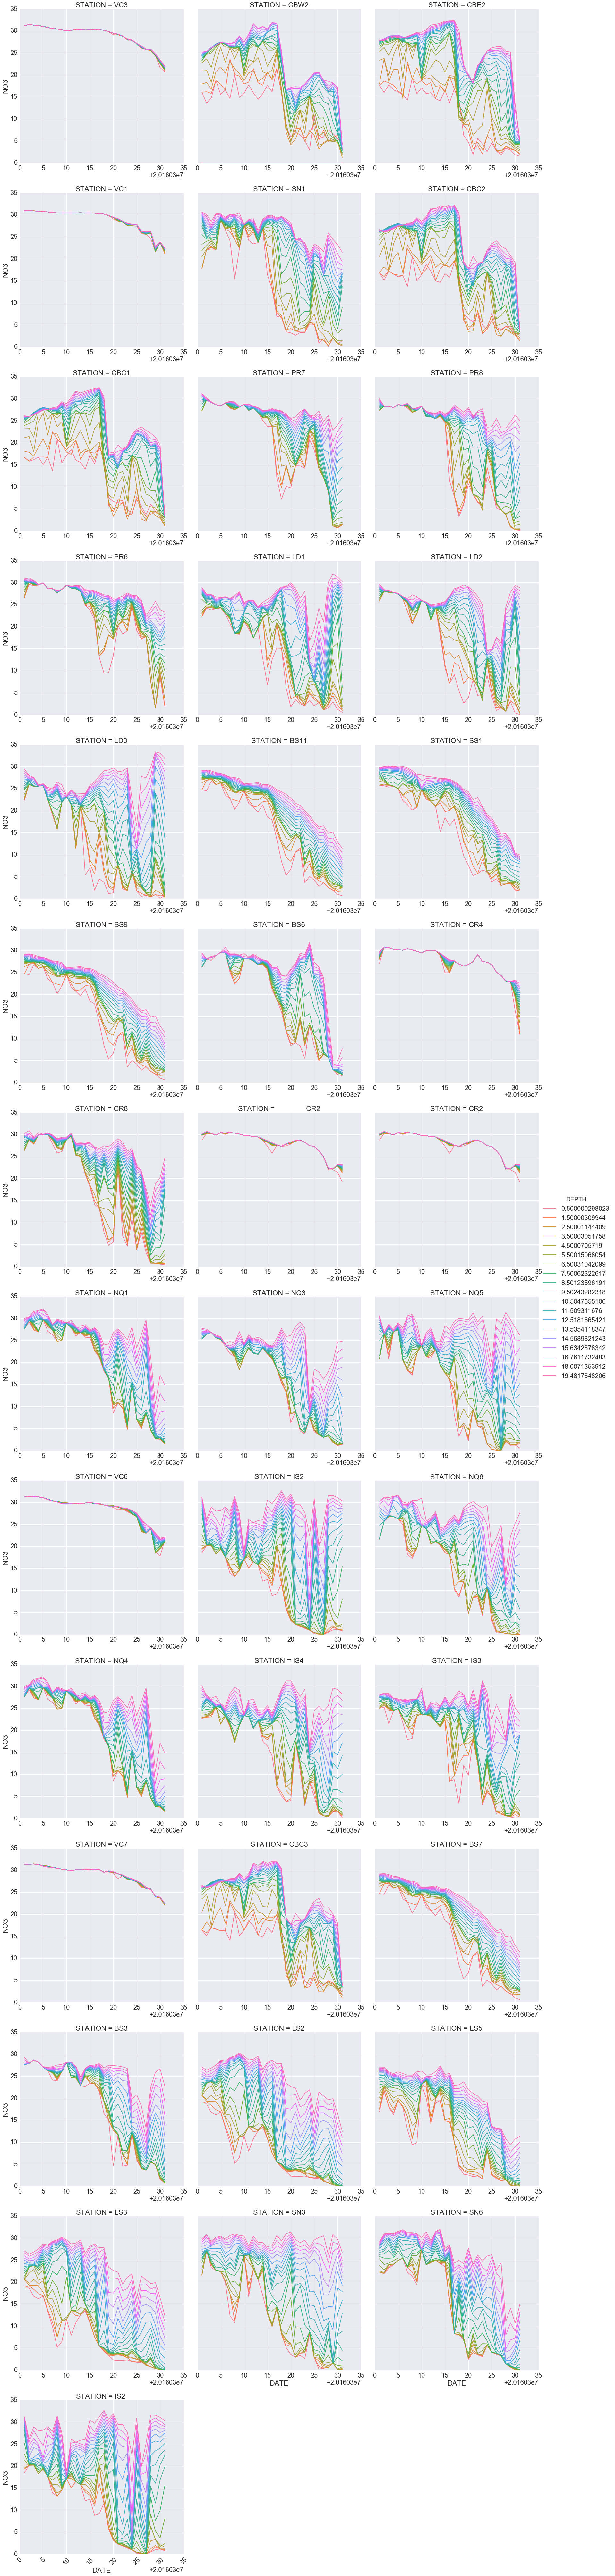

In [69]:
# Plot nowcast data
nowcast_df
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = nowcast_df.query("MONTH == 3"), col = "STATION", col_wrap=3, hue = "DEPTH", size =8, sharex = False)
fg.map(plt.plot,"DATE", "NO3").add_legend()
plt.xticks(rotation=45)

(array([ 735744.,  735746.,  735748.,  735750.,  735752.,  735754.,
         735756.,  735758.]), <a list of 8 Text xticklabel objects>)

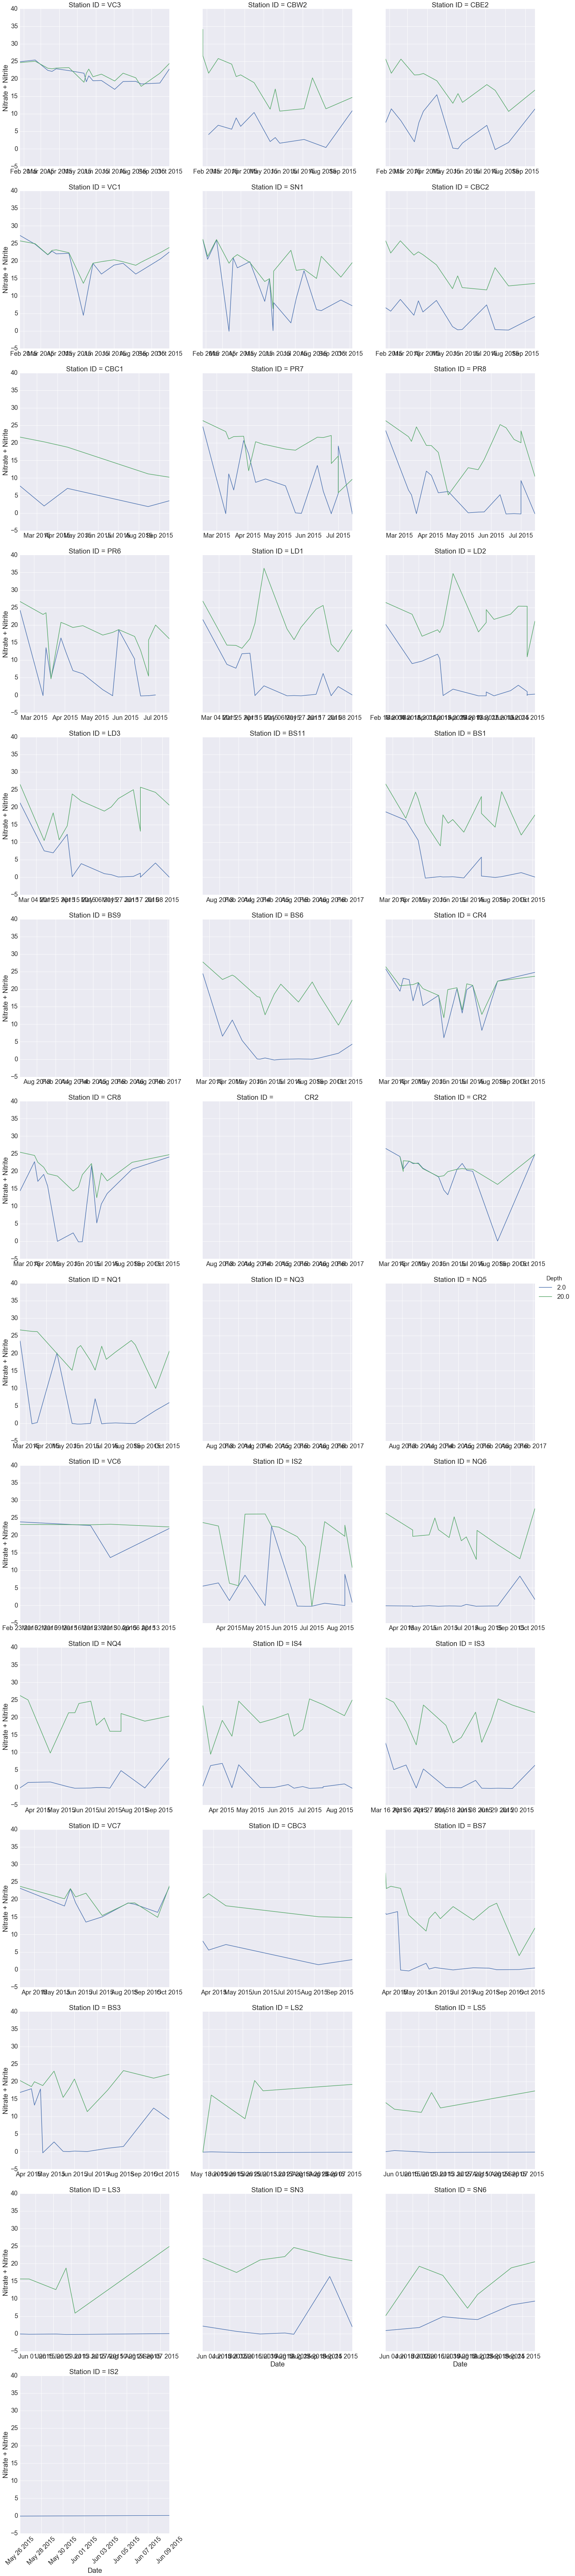

In [41]:
# Plot nitrate data
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = nitrate_df, col = "Station ID", col_wrap=3, hue = "Depth", size =8, sharex = False)
fg.map(plt.plot,"Date", "Nitrate + Nitrite").add_legend()
plt.xticks(rotation=45)